<a href="https://colab.research.google.com/github/rahiakela/computer-vision-research-and-practice/blob/main/using-stable-diffusion-with-python/01_introduction_to_stable_diffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Generate image from text

In [ ]:
# install diffusers
%pip install -U diffusers

In [ ]:
import torch
from diffusers import StableDiffusionPipeline

In [ ]:
pipeline = StableDiffusionPipeline.from_pretrained(
    "stablediffusionapi/deliberate-v2"
    , torch_dtype = torch.float16
).to("cuda:0")

  0%|          | 0/50 [00:00<?, ?it/s]

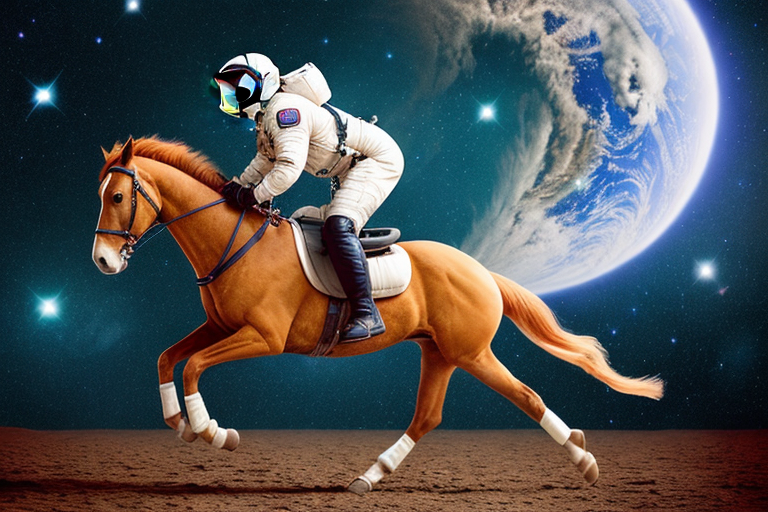

In [ ]:
prompt = "a photograph of an astronaut riding a horse"
image = pipeline(
    prompt          = prompt
    , generator     = torch.Generator("cuda:0").manual_seed(6)
    , width         = 768
    , height        = 512
).images[0]

display(image)

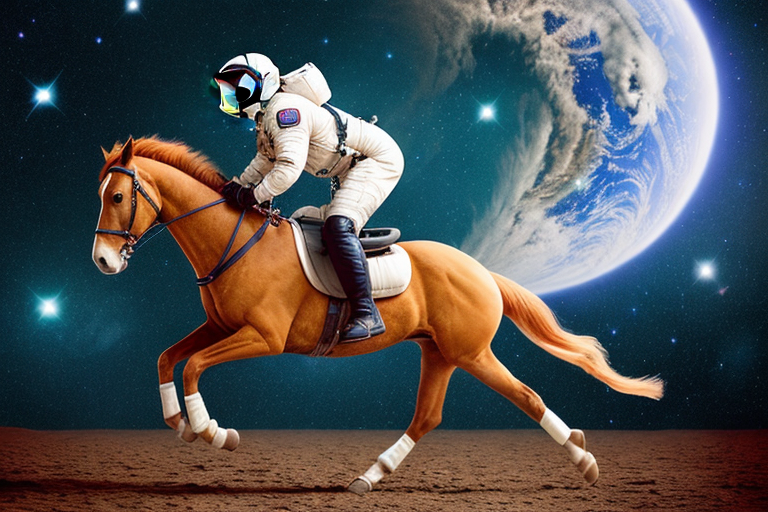

In [ ]:
image

## Detect the backgroud

In [ ]:
from transformers import CLIPSegProcessor,CLIPSegForImageSegmentation

In [ ]:
processor = CLIPSegProcessor.from_pretrained(
    "CIDAS/clipseg-rd64-refined"
)
model = CLIPSegForImageSegmentation.from_pretrained(
    "CIDAS/clipseg-rd64-refined"
)

Unused or unrecognized kwargs: padding.


torch.Size([352, 352])


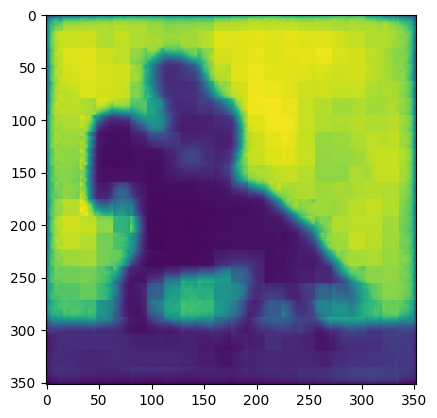

In [ ]:
# generate mask data
import matplotlib.pyplot as plt

prompts = ['the background']
inputs = processor(
    text             = prompts
    , images         = [image] * len(prompts)
    , padding        = True
    , return_tensors = "pt"
)

with torch.no_grad():
    outputs = model(**inputs)

preds = outputs.logits

mask_data = torch.sigmoid(preds)[0]
print(mask_data.shape)
plt.imshow(mask_data)

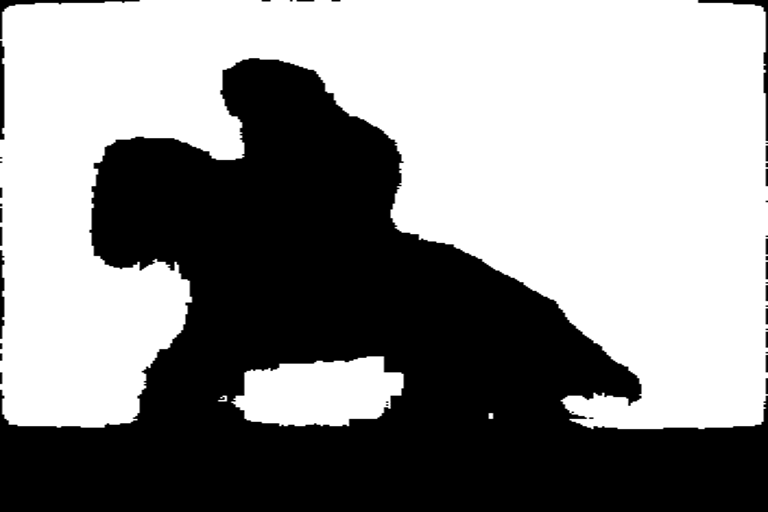

In [ ]:
# genearte mask binary image
import cv2
from PIL import Image

mask_file_name = f"bg_mask.png"
plt.imsave(mask_file_name,mask_data)
mask_data_cv = cv2.imread(mask_file_name) # -> (352, 352, 3)

def get_mask_img(mask_data):
    gray_image = cv2.cvtColor(mask_data,cv2.COLOR_BGR2GRAY)
    thresh, bw_image = cv2.threshold(gray_image,100,255,cv2.THRESH_BINARY)
    cv2.cvtColor(bw_image, cv2.COLOR_BGR2RGB)
    return Image.fromarray(bw_image)

bw_image = get_mask_img(mask_data=mask_data_cv)
#cv2.imwrite(bw_image)
bw_image = bw_image.resize((768,512))
bw_image

In [ ]:
# Start a inpaint pipeline
from diffusers import StableDiffusionInpaintPipeline, EulerDiscreteScheduler

inpaint_pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "CompVis/stable-diffusion-v1-4"
    , torch_dtype = torch.float16
    , safety_checker = None
).to("cuda:0")
#inpaint_pipe.scheduler = EulerDiscreteScheduler.from_config(inpaint_pipe.scheduler.config)

  0%|          | 0/45 [00:00<?, ?it/s]

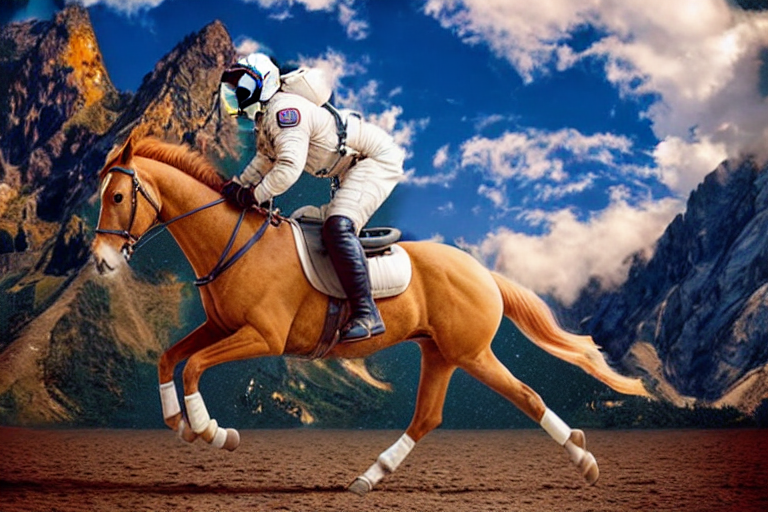

In [ ]:
# change the background
sd_prompt = "blue sky and mountains"
out_image = inpaint_pipe(
    prompt          = sd_prompt
    , image         = image
    , mask_image    = bw_image
    , strength      = 0.9
    , generator     = torch.Generator("cuda:0").manual_seed(7)
    # , guidance_scale = 7.5
    # , num_inference_steps = 50
    # , width = 768
    # , height = 512
).images[0]

out_image